# Data Visualization

In [1]:
# import important libraies
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk import bigrams
from collections import Counter
from sklearn.feature_extraction.text import CountVectorize


# Download necessary NLTK resources if not already available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/amy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/amy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/amy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Loading

In [2]:
# Load df1
df1 = pd.read_csv('cleaned_df.csv')

# Load df2 and rename columns to match df1
df2 = pd.read_csv('tweets_scraped_labeled.csv')
df2.rename(columns={'snippet': 'text'}, inplace=True)

# Define the columns to retain
columns_to_retain = ['target', 'text']

# Retain only the necessary columns in df1 and df2
df1 = df1[columns_to_retain]
df2 = df2[columns_to_retain]

# Combine the DataFrames
df = pd.concat([df1, df2], axis=0)

# Replace target values
df['target'] = df['target'].replace({0: 'Negative', 1: 'Positive'})

In [5]:
# check shape and head of df
print(df.shape)
df.head()

(1600099, 2)


,target,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


### Data preprocessing for visualization

In the following analysis, I skip stemming or lemmatization in the cleaning process to preserve the original context and meaning of tweets. This is key for accurate visualizations, as it maintains the full nuances and sentiments expressed in the original text.

In [6]:
# check nan value
df.isna().sum()

target    0
text      0
dtype: int64

In [9]:
# check duplicates
df.duplicated().sum()

16309

In [11]:
# 16309/1600099 is around 1% of whole dataset, therefore drop dumplicate

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
# Function to load stopwords from a custom file
def load_stopwords(filepath):
    stopwords = set()
    with open(filepath, "r") as file:
        for word in file:
            # Strip whitespace and convert to lowercase before adding to the set
            stopwords.add(word.strip().lower())
    return stopwords

# Load your custom stopwords
custom_stopwords = load_stopwords("stopwords_cust.txt") # Ensure the file path is correct

# Function for cleaning and tokenizing text with additional processing
def clean_tokenize_filter(text, stopwords):
    lemmatizer = WordNetLemmatizer()
    try:
        # Regular expression patterns for removing URLs, user mentions, HTML entities, and non-alphabetic characters
        url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
        user_pattern = r"@[^\s]+"
        entity_pattern = r"&.*;"
        neg_contraction = r"n't\W"
        non_alpha = "[^a-z]"

        # Lowercasing and cleaning the text based on the defined patterns
        cleaned_text = text.lower()
        cleaned_text = re.sub(neg_contraction, " not ", cleaned_text) # Expand negative contractions for better analysis
        cleaned_text = re.sub(url_pattern, " ", cleaned_text) # Remove URLs
        cleaned_text = re.sub(user_pattern, " ", cleaned_text) # Remove user mentions
        cleaned_text = re.sub(entity_pattern, " ", cleaned_text) # Remove HTML entities
        cleaned_text = re.sub(non_alpha, " ", cleaned_text) # Keep only alphabetic characters

        # Tokenize the cleaned text and perform POS tagging
        tokens = word_tokenize(cleaned_text)
        word_tag_tuples = pos_tag(tokens, tagset="universal")

        # Map NLTK's POS tags to the format required by the WordNet lemmatizer
        tag_dict = {"NOUN": "n", "VERB": "v", "ADJ": "a", "ADV": "r"}

        final_tokens = []
        # Lemmatize words based on their POS tags, excluding stopwords and single characters
        for word, tag in word_tag_tuples:
            if len(word) > 1 and word not in stopwords:
                final_tokens.append(lemmatizer.lemmatize(word, tag_dict.get(tag, 'n')))
        
        return " ".join(final_tokens)
    except Exception as e:
        # Print the exception message and return NaN in case of an error
        print(f"Error in text processing: {e}")
        return np.nan


In [14]:
df['processed_content'] = df['text'].apply(lambda x: clean_tokenize_filter(x, custom_stopwords))

In [15]:
df.head()

,target,text,processed_content
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda get david carr third day
1,Negative,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,Negative,@Kenichan I dived many times for the ball. Man...,dive many time ball manage save rest go bound
3,Negative,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,Negative,"@nationwideclass no, it's not behaving at all....",behave mad see


In [16]:
# Saving df to a CSV file
df.to_csv('dataset_visualization.csv', index=False)

### User-Defined Search Term and Tweet Count

In [30]:
# User input for search term
user_search_term = input("Enter the search term: ")

# Filter the DataFrame based on the search term
filtered_df = df[df['processed_content'].str.contains(user_search_term, case=False, na=False)]

# Display the total number of tweets related to the search term
total_related_tweets = len(filtered_df)
print(f"Total tweets containing '{user_search_term}': {total_related_tweets}")

valid_input = False
while not valid_input:
    # User input for number of tweets to analyze
    user_num_tweets = int(input(f"Enter the number of tweets to analyze (max {total_related_tweets}): "))

    # Validate the user input to not exceed the total number of related tweets
    if user_num_tweets > total_related_tweets:
        print(f"Please enter a number less than or equal to {total_related_tweets}.")
    else:
        valid_input = True

# Filter to keep only the specified number of tweets
filtered_df = filtered_df.head(user_num_tweets)


Enter the search term: KFC
Total tweets containing 'KFC': 232
Enter the number of tweets to analyze (max 232): 230


In [31]:
filtered_df

,target,text,processed_content
4955,Negative,"goood morning sheffield, who the fuck text me ...",goood morning sheffield fuck text morning kfc ...
9476,Negative,Wont go back to KFC for a while. Where KFC fa...,wont go back kfc kfc fail ordered usual fave g...
9679,Negative,I just ate KFC,eat kfc
18824,Negative,@Xenex someone tweeter back to me that it's KF...,someone tweeter back kfc version mccafe hop di...
28952,Negative,KFC + pizza hut =&gt; deadly combi. too full t...,kfc pizza hut deadly combi full sleep
...,...,...,...
1548370,Positive,@Keryje @Lopsi &amp; @lynniebean27 R marrying ...,witness happen dingle kfc cater
1552219,Positive,"who knew that a KFC, Sex and the City and a bo...",know kfc sex city bottle white wine make feel ...
1560849,Positive,"Having a little meal w @MaEugenia at KFC, a go...",little meal kfc good taste fat chicken sorry s...
1562903,Positive,Twitter Time! Eubi doesn't deserve one of the...,twitter time eubi deserve one new kfc burger i...


### Graph 1: Sentiment Distribution

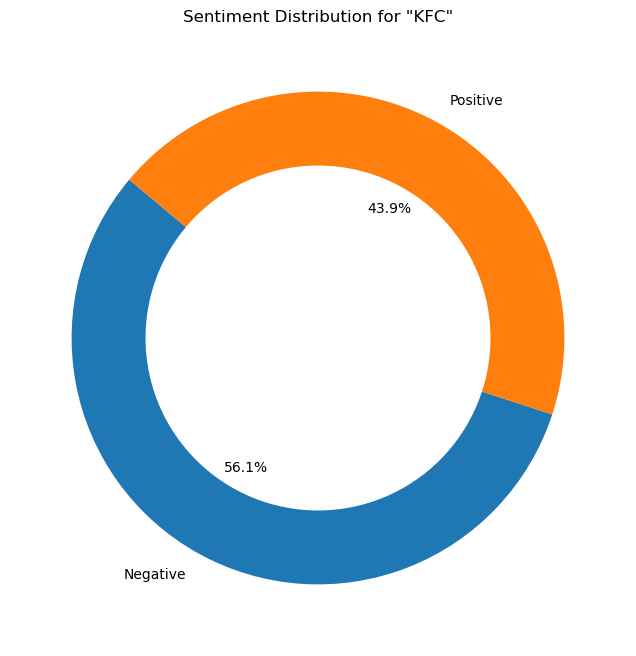

In [32]:
# Sentiment Distribution (Donut Chart)
def plot_sentiment_distribution(filtered_df, search_term):
    sentiment_counts = filtered_df['target'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
    plt.title(f'Sentiment Distribution for "{search_term}"')
    plt.show()

# Use the function
plot_sentiment_distribution(filtered_df, user_search_term)


### Graph 2: Top 10 Occurring Words

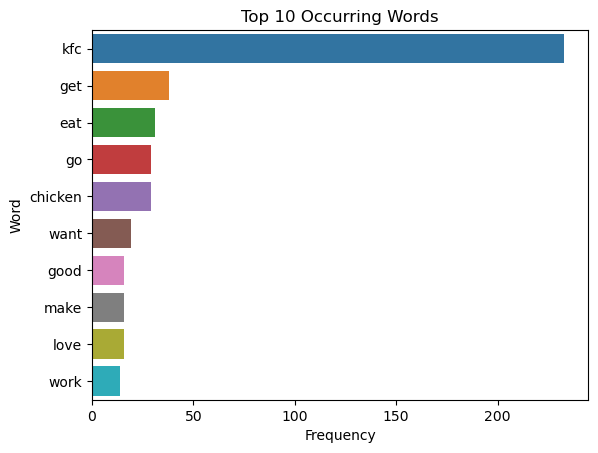

In [33]:
# Top 10 Occurring Words
def plot_top_words(filtered_df):
    all_words = ' '.join(filtered_df['processed_content']).split()
    word_freq = Counter(all_words)
    top_words = pd.DataFrame(word_freq.most_common(10), columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=top_words)
    plt.title('Top 10 Occurring Words')
    plt.show()

# Use the function
plot_top_words(filtered_df)

### Graph 3: Top 10 Occurring Bigrams

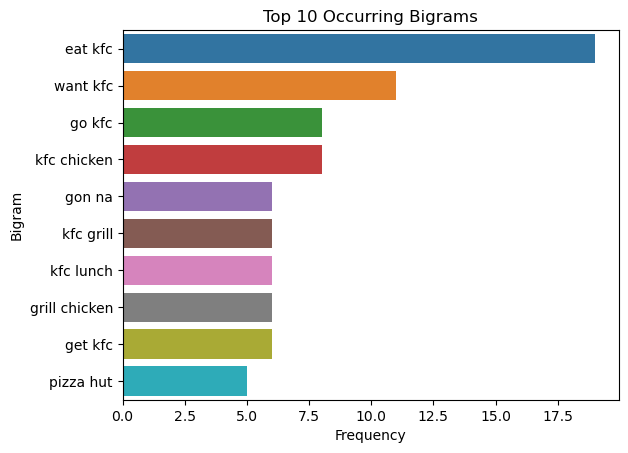

In [38]:
def plot_top_bigrams(filtered_df, n=10, stopwords_file="stopwords_cust.txt"):
    # Load custom stopwords
    stopwords = set()
    with open(stopwords_file, "r") as file:
        for word in file:
            stopwords.add(word.strip())

    # Convert the set of stopwords to a list
    stopwords_list = list(stopwords)

    # Prepare the corpus
    corpus = filtered_df['processed_content']

    # Initialize CountVectorizer for bigrams with custom stopwords
    vectorizer = CountVectorizer(analyzer="word", ngram_range=(2, 2), stop_words=stopwords_list)

    # Apply the vectorizer to the corpus
    X = vectorizer.fit_transform(corpus)
    bigram_names = vectorizer.get_feature_names_out()
    bigram_counts = np.ravel(X.sum(axis=0))

    # Create a DataFrame for bigrams and their counts
    bigram_df = pd.DataFrame({'Bigram': bigram_names, 'Frequency': bigram_counts})
    top_bigrams = bigram_df.sort_values(by="Frequency", ascending=False).head(n)

    # Plotting the top bigrams
    sns.barplot(x='Frequency', y='Bigram', data=top_bigrams)
    plt.title(f'Top {n} Occurring Bigrams')
    plt.show()

# Example usage
plot_top_bigrams(filtered_df, n=10, stopwords_file="stopwords_cust.txt")


### Graph 4: First 10 Tweets with Sentiment

In [35]:
# Function to print a random sample of 10 tweets with sentiment
def print_sample_10_tweets(filtered_df):
    if len(filtered_df) < 10:
        sample_10_tweets = filtered_df[['target', 'text']]
    else:
        sample_10_tweets = filtered_df[['target', 'text']].sample(10)
    
    # Resetting the index and setting `drop=True` to avoid adding the old index as a column
    sample_10_tweets.reset_index(drop=True, inplace=True)
    print(sample_10_tweets)

# Use the function
print_sample_10_tweets(filtered_df)


     target                                               text
0  Negative  didn't manage to have McD's or KFC today  Ende...
1  Positive  I know what I'm gonna have today, I high calor...
2  Positive  slumdog millionaire suuuuuuuuuch an amazing mo...
3  Negative  blond girl in cosham kfc talks like she has 14...
4  Negative  I ate a piece of KFC chicken. Bad idea. I feel...
5  Positive  First blog post in a while, I needed something...
6  Positive  Meeting with the bank. Is KFC the most closely...
7  Positive                       Drinking Free KFC Coke  xoxo
8  Negative  You know times are tough when they close down ...
9  Negative                          could really go some kfc 


### Graph 5: Word Cloud

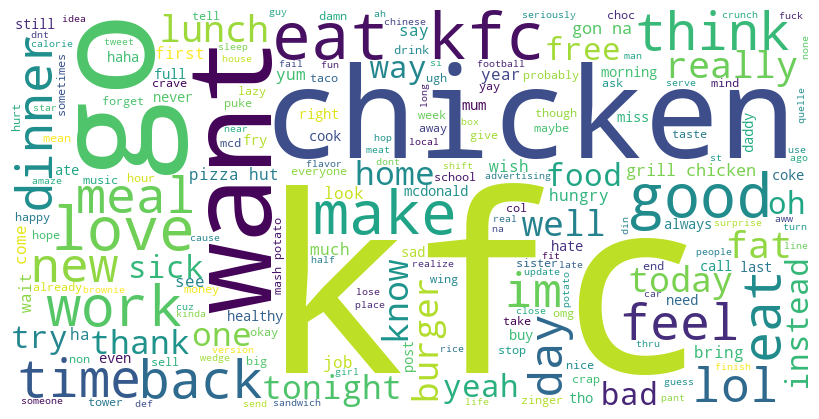

In [36]:
# Word Cloud
def plot_wordcloud(filtered_df):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(filtered_df['processed_content']))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

# Use the function
plot_wordcloud(filtered_df)
